# BAN6800-Module-4-Business-Analytics-Model
# Shield360 Project - Customer Churn Prediction Model
# Voke H Edafejimue

### IMPORT LIBRARIES

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, recall_score, f1_score, confusion_matrix, roc_auc_score, RocCurveDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
import joblib
import pickle
import dash
from dash import dcc, html
import plotly.express as px
import plotly.graph_objs as go
from dash.dependencies import Input, Output
import numpy as np

###  Load Dataset

In [2]:
#Load the dataset
df = pd.read_csv("telco_churn_cleaned.csv")
df.shape

(7043, 76)

### Data Review & Cleansing

In [37]:
# Show duplicate column names
duplicate_columns = df.columns[df.columns.duplicated()]
print("Duplicate Columns:\n", duplicate_columns)

# Drop duplicate columns (keep the first occurrence)
df = df.loc[:, ~df.columns.duplicated()]

# Drop non-predictive columns
df = df.drop(['Churn Label', 'Churn Reason', 'Churn Score', 'Customer Status',
    'Churn Category', 'CLTV', 'Total Refunds', 'CustomerID', 'ID', 'Customer ID', 'Country', 'State', 
    'City', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Backup', 
    'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Under 30', 
    'Married', 'Population', 'Quarter', 'Device Protection Plan', 'Premium Tech Support', 
    'Streaming Music', 'Unlimited Data', 'Contract_One year', 'Contract_Two year', 
    'Payment Method_Credit card (automatic)', 'Payment Method_Electronic check', 
    'Payment Method_Mailed check', 'Internet Type_DSL', 'Internet Type_Fiber Optic', 
    'Internet Type_None', 'Offer_Offer A', 'Offer_Offer B', 'Offer_Offer C', 
    'Offer_Offer D', 'Offer_Offer E', 'Contract_One year.1', 'Contract_Two year.1', 
    'Payment Method_Credit card (automatic).1', 'Payment Method_Electronic check.1', 
    'Payment Method_Mailed check.1', 'Internet Type_DSL.1', 'Internet Type_Fiber Optic.1', 
    'Internet Type_None.1', 'Offer_Offer A.1', 'Offer_Offer B.1', 'Offer_Offer C.1', 
    'Offer_Offer D.1', 'Offer_Offer E.1'], axis=1, errors='ignore')

# Convert Total Charges to numeric
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')
df['Total Charges'].fillna(df['Total Charges'].median(), inplace=True)

# Encode target variable
df['Churn Value'] = df['Churn Value'].astype(int)

# Encode categorical features
cat_cols = df.select_dtypes(include='object').columns
df[cat_cols] = df[cat_cols].apply(LabelEncoder().fit_transform)

df.info()
df.head()

Duplicate Columns:
 Index([], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Zip Code                           7043 non-null   int64  
 1   Gender                             7043 non-null   int64  
 2   Partner                            7043 non-null   int64  
 3   Dependents                         7043 non-null   int64  
 4   Tenure Months                      7043 non-null   int64  
 5   Online Security                    7043 non-null   int32  
 6   Paperless Billing                  7043 non-null   int64  
 7   Monthly Charges                    7043 non-null   float64
 8   Total Charges                      7043 non-null   float64
 9   Churn Value                        7043 non-null   int32  
 10  Age                                7043 non-null   int64  
 11  Number of 

,Zip Code,Gender,Partner,Dependents,Tenure Months,Online Security,Paperless Billing,Monthly Charges,Total Charges,Churn Value,...,Number of Dependents,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Satisfaction Score
0,90003,1,0,0,2,2,1,53.85,108.15,1,...,0,0,0.014085,0.209442,0.247059,0.354229,0,20.94,0.009009,1
1,90005,0,0,1,2,0,1,70.70,151.65,1,...,2,0,0.014085,0.182436,0.600000,0.521891,0,18.24,0.012421,2
2,90006,0,0,1,8,0,1,99.65,820.50,1,...,2,0,0.098592,0.243049,0.305882,0.809950,0,97.20,0.074957,3
3,90010,0,1,1,28,0,1,104.80,3046.05,1,...,3,0,0.380282,0.097820,0.552941,0.861194,0,136.92,0.264393,3
4,90015,1,0,1,49,0,1,103.70,5036.30,1,...,1,0,0.676056,0.886777,0.129412,0.850249,0,2172.17,0.601030,1


### Train/Test Split

In [39]:
# Create X (features) and y (target) datasets
X = df.drop(['Customer ID', 'Churn Value'], axis=1, errors='ignore')
y = df['Churn Value']
feature_names = X.columns.tolist()

# using the train/test split function
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42, test_size = 0.2, shuffle = True)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Confirm the splitting is correct:
print("Shape of Training Data : ", "\nfeatures:", X_train.shape, ", target:", y_train.shape)
print("Target Label Distribution in train set : ", "\nChurn:", y_train.sum(), ", Not Churn:", len(y_train) - y_train.sum())
print("Percentage of Churn:", y_train.sum() / len(y_train) * 100)
print()
print("Shape of Test Data : ", "\nfeatures:", X_test.shape, ", target:", y_test.shape)
print("Target Label Distribution in test set : ", "\nChurn:", y_test.sum(), ", Not Churn:", len(y_test) - y_test.sum())
print("Percentage of Churn:", y_test.sum() / len(y_test) * 100)

#Data Prep for Pipeline
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Column transformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

print("Categorical features:", categorical_features)
print("Numerical features:", numeric_features)

Shape of Training Data :  
features: (5634, 20) , target: (5634,)
Target Label Distribution in train set :  
Churn: 1495 , Not Churn: 4139
Percentage of Churn: 26.53532126375577

Shape of Test Data :  
features: (1409, 20) , target: (1409,)
Target Label Distribution in test set :  
Churn: 374 , Not Churn: 1035
Percentage of Churn: 26.54364797728886
Categorical features: []
Numerical features: ['Zip Code', 'Gender', 'Partner', 'Dependents', 'Tenure Months', 'Paperless Billing', 'Monthly Charges', 'Total Charges', 'Age', 'Number of Dependents', 'Number of Referrals', 'Tenure in Months', 'Avg Monthly Long Distance Charges', 'Avg Monthly GB Download', 'Monthly Charge', 'Total Extra Data Charges', 'Total Long Distance Charges', 'Total Revenue', 'Satisfaction Score']


## Modeling


=== Evaluating Logistic_regression ===
Train F1 Score: 0.9053164255688981
Test F1 Score: 0.9073952363426048
Test Recall: 0.9004624247591


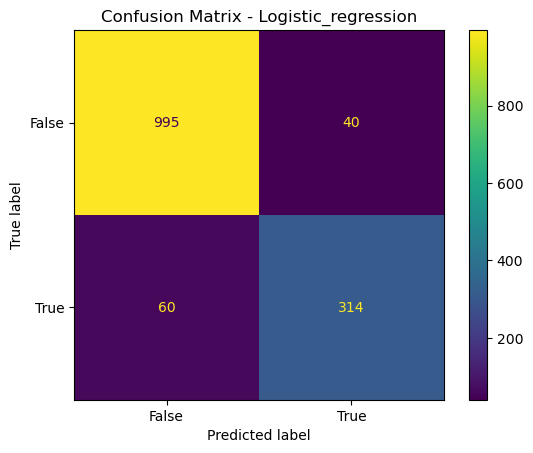


=== Evaluating Decision_tree ===
Train F1 Score: 0.936111822441873
Test F1 Score: 0.9328446328536953
Test Recall: 0.9170335064196957


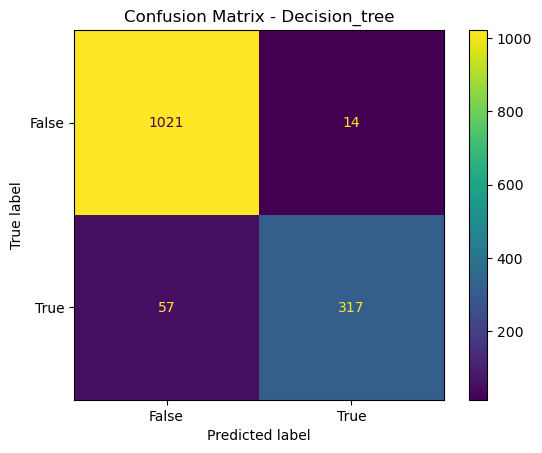


=== Evaluating Random_forest ===
Train F1 Score: 0.9306626389372991
Test F1 Score: 0.9269456110333385
Test Recall: 0.9005864269291379


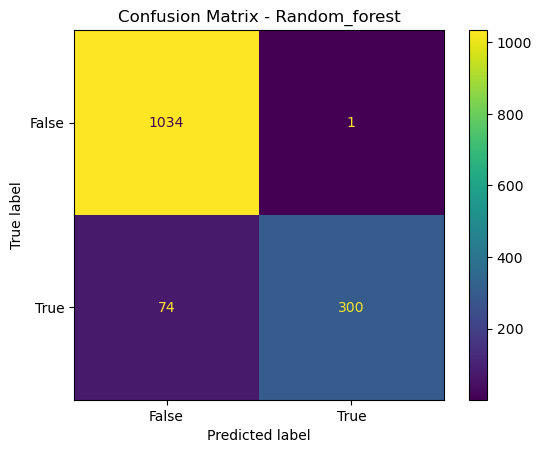


=== Evaluating GBDT ===
Train F1 Score: 0.981857462179812
Test F1 Score: 0.9388649582097582
Test Recall: 0.9250548967940273


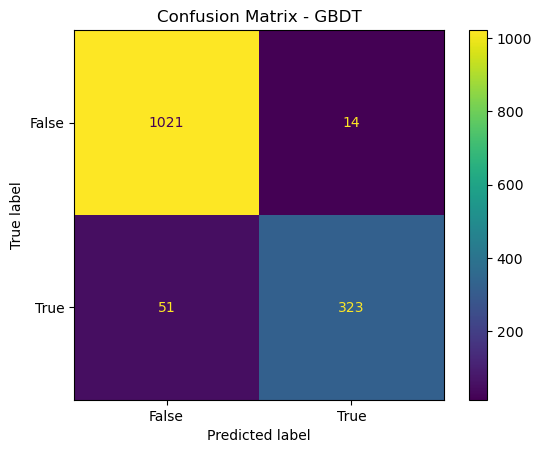


=== Evaluating Neural_Network ===


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
Train F1 Score: 0.9526379939816974
Test F1 Score: 0.9347726441402702
Test Recall: 0.9306944121522127


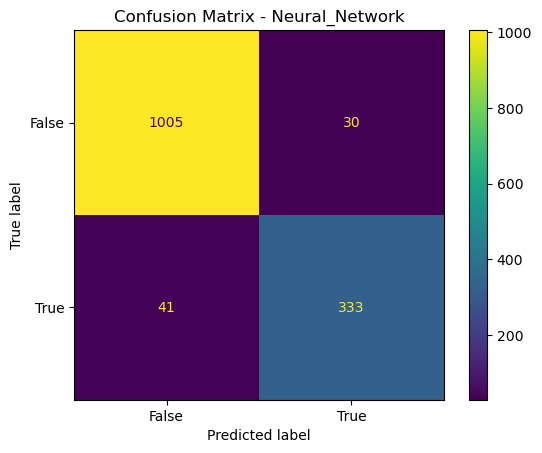

In [41]:
# Define a dictionary of models
list_of_models = {
    'Logistic_regression' : LogisticRegression(random_state=42, max_iter=10000),
    'Decision_tree' : DecisionTreeClassifier(max_depth=5, random_state=42),
    'Random_forest' : RandomForestClassifier(n_estimators=150, max_depth=4, random_state=42),
    'GBDT' : GradientBoostingClassifier(n_estimators=150, max_depth=4, random_state=42),
    'Neural_Network': 'Keras'  # Placeholder
}

# define empty lists to populate scores.
f1_train_scores = [] 
f1_test_scores = [] 
recall_test_scores = []

model_names = list_of_models.keys()

for model_name in model_names:
    print(f"\n=== Evaluating {model_name} ===")

    if model_name == 'Neural_Network':
        # Build and train MLP model using Keras
        nn_model = Sequential([
            Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
            Dropout(0.3),
            Dense(32, activation='relu'),
            Dropout(0.3),
            Dense(1, activation='sigmoid')
        ])

        nn_model.compile(optimizer=Adam(learning_rate=0.001),
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

        nn_model.fit(X_train_scaled, y_train, epochs=30, batch_size=32,
                     validation_split=0.2, verbose=0)

        # Predictions
        y_train_pred_nn = (nn_model.predict(X_train_scaled) > 0.5).astype(int)
        y_test_pred_nn = (nn_model.predict(X_test_scaled) > 0.5).astype(int)

        #Cross-validation
        cross_val_score(model, X, y, cv=5, scoring='f1_macro')

        # Evaluation
        f1_train = f1_score(y_train, y_train_pred_nn, average='macro')
        f1_test = f1_score(y_test, y_test_pred_nn, average='macro')
        recall_test_score = recall_score(y_test, y_test_pred_nn, average='macro')

        print(f"Train F1 Score: {f1_train}")
        print(f"Test F1 Score: {f1_test}")
        print(f"Test Recall: {recall_test_score}")

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_test_pred_nn)
        metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False, True]).plot()
        plt.title(f"Confusion Matrix - {model_name}")
        plt.show()

    else:
        model = list_of_models[model_name]
        model.fit(X_train, y_train)

        # Predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        #Cross-validation
        cross_val_score(model, X, y, cv=5, scoring='f1_macro')

        f1_train = f1_score(y_train, y_train_pred, average='macro')
        f1_test = f1_score(y_test, y_test_pred, average='macro')
        recall_test_score = recall_score(y_test, y_test_pred, average='macro')

        print(f"Train F1 Score: {f1_train}")
        print(f"Test F1 Score: {f1_test}")
        print(f"Test Recall: {recall_test_score}")

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_test_pred)
        metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False, True]).plot()
        plt.title(f"Confusion Matrix - {model_name}")
        plt.show()

    # Save metrics
    f1_train_scores.append(f1_train)
    f1_test_scores.append(f1_test)
    recall_test_scores.append(recall_test_score)

### Model Performance Evaluation for Selection

In [43]:
# Display the results in tabular form.
results_df = pd.DataFrame({
    'Model': list(model_names),
    'F1 Score (Train)': f1_train_scores,
    'F1 Score (Test)': f1_test_scores,
    'Recall (Test)': recall_test_scores
})

results_df.sort_values(by='F1 Score (Test)', ascending=False) # sorted by F1 Score (Test)

,Model,F1 Score (Train),F1 Score (Test),Recall (Test)
3,GBDT,0.981857,0.938865,0.925055
4,Neural_Network,0.952638,0.934773,0.930694
1,Decision_tree,0.936112,0.932845,0.917034
2,Random_forest,0.930663,0.926946,0.900586
0,Logistic_regression,0.905316,0.907395,0.900462


### Chosen Model Evaluation

[[1021   14]
 [  51  323]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      1035
           1       0.96      0.86      0.91       374

    accuracy                           0.95      1409
   macro avg       0.96      0.93      0.94      1409
weighted avg       0.95      0.95      0.95      1409



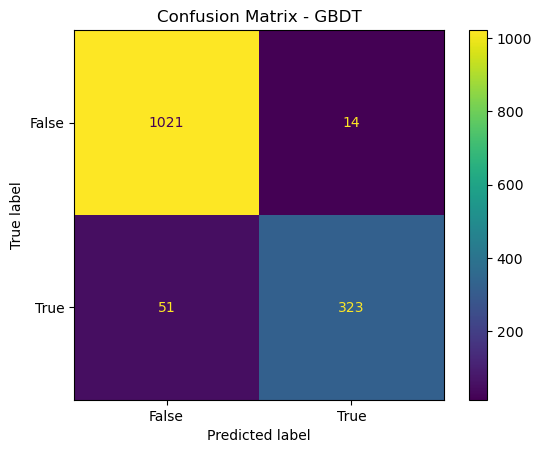

AUC Score: 0.9892996460771396


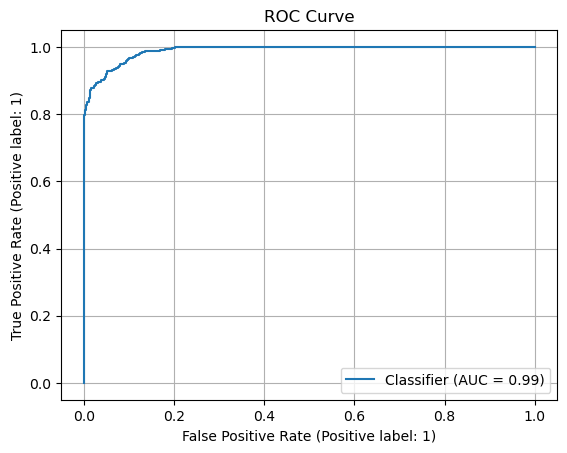

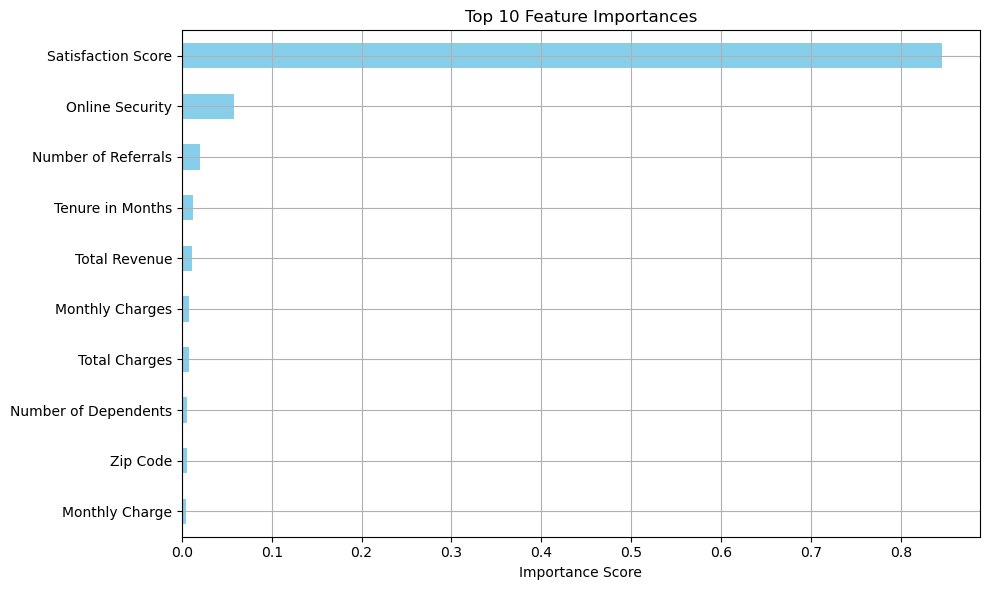

In [45]:
# Select the trained model from the dictionary

final_model_name = 'GBDT'
model = list_of_models[final_model_name]

# Predictions
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))

# Classification Metrics
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = metrics.confusion_matrix(y_test, y_pred)
metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False, True]).plot()
plt.title(f"Confusion Matrix - {final_model_name}")
plt.show()

# ROC AUC Score
y_pred_probs = model.predict_proba(X_test)[:, 1]  # Get probability for class 1
auc = roc_auc_score(y_test, y_pred_probs)
print("AUC Score:", auc)

# Plot the ROC curve
RocCurveDisplay.from_predictions(y_test, y_pred_probs)
plt.title("ROC Curve")
plt.grid(True)
plt.show()

# Make sure you're using a model that has the attribute 'feature_importances_'
if hasattr(model, 'feature_importances_'):
    # Create a Series with feature importances
    importances = pd.Series(model.feature_importances_, index=X.columns)

    # Sort and plot the top 10 features
    top_features = importances.sort_values(ascending=False).head(10)

    # Plot
    plt.figure(figsize=(10, 6))
    top_features.plot(kind='barh', color='skyblue')
    plt.gca().invert_yaxis()  # Highest importance at the top
    plt.title("Top 10 Feature Importances")
    plt.xlabel("Importance Score")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("The selected model does not support feature importance.")


### Save the Model

In [47]:
# Load cleaned dataset
df = pd.read_csv('telco_churn_cleaned.csv')  # Make sure it's clean and matches the model

# Full pipeline with GBDT
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', GradientBoostingClassifier())
])

# Your trained model
model = GradientBoostingClassifier()

# Train the model (using some data, e.g., X_train, y_train)
model.fit(X_train, y_train)

# Save the entire trained model (not just predictions)
with open('gbdt_model.pkl', 'wb') as f:
    pickle.dump(model, f)
    print("GBDT model successfully saved")
    
# Save to file using pickle
with open('gbdt_features.pkl', 'wb') as f:
    pickle.dump(feature_names, f)
    print("GBDT Features successfully saved")
# Save the pipeline
with open('pipeline.pkl', 'wb') as f:
    pickle.dump(pipeline, f)
    print("GBDT Pipeline successfully saved")


GBDT model successfully saved
GBDT Features successfully saved
GBDT Pipeline successfully saved


In [49]:
model_file = './gbdt_model.pkl'
features_file = './gbdt_features.pkl'

with open(model_file, 'rb') as f:
    model = pickle.load(f)

with open(features_file, 'rb') as f:
    features = pickle.load(f)

# Now 'features' contains the data that was stored in the .pkl file
# Print the contents to inspect
print(features)

num_features = len(features)
print(f"Number of features: {num_features}")

['Zip Code', 'Gender', 'Partner', 'Dependents', 'Tenure Months', 'Online Security', 'Paperless Billing', 'Monthly Charges', 'Total Charges', 'Age', 'Number of Dependents', 'Number of Referrals', 'Tenure in Months', 'Avg Monthly Long Distance Charges', 'Avg Monthly GB Download', 'Monthly Charge', 'Total Extra Data Charges', 'Total Long Distance Charges', 'Total Revenue', 'Satisfaction Score']
Number of features: 20


### Conclusion

#### The GBDT model outperforms the other models on the training and test datasets. The Multilayer Perceptron (MLP), Decision Tree, and Random Forest models performed well too. Though considered the simplest and easiest to understand, the Logistic Regression model had the lowest F1 score.

#### An AUC score of 0.99 suggests that there is a 99% chance that the GBDT model will correctly identify a subscriber with high churn risk. The model is reliable and can be confidently used to carry out subscriber retention strategies.

#### Features like the 'Satisfaction score' prove to be the most important factor in the dataset. Other features also play vital roles in the chosen models.


### References

#### Natassha Selvaraj. February 1, 2024. How to Build a Customer Churn Prediction Model in Python? 365 Data Science. https://365datascience.com/tutorials/python-tutorials/how-to-build-a-customer-churn-prediction-model-in-python/
#### 	Himanshi Singh. November 18, 2024. 10 Techniques to Solve Imbalanced Classes in Machine Learning. Analytics Vidhya. https://www.analyticsvidhya.com/articles/class-imbalance-in-machine-learning

#### Adiaturb. June 6, 2023. Customer Churn Prediction with Python — End-to-End Machine Learning Project. Medium. https://medium.com/@adiaturb/customer-churn-prediction-with-python-end-to-end-machine-learning-project-93ccc6b2218f

#### Luca Petriconi. August 11, 2021. Churn Modeling: A detailed step-by-step Guide in Python. Medium. https://medium.com/@lucapetriconi/churn-modeling-a-detailed-step-by-step-guide-in-python-1e96d51c75233

